# 13. Portfolio Optimization with Reinforcement Learning

This tutorial provides a step-by-step guide for implementing a Unit Operator with a Portfolio Strategy in the ASSUME framework. By the end of this guide, you will be familiar with the process of creating and integrating a Portfolio within the electricity market simulation environment provided by ASSUME.


**We will cover the following topics:**

1. [Introduction to Unit Operators and Portfolio Strategy](#1.-introduction-to-unit-operators-and-portfolio-strategy)
2. [Setting up the ASSUME framework](#2.-setting-up-assume)
3. [Developing a portfolio RL strategy](#3.-portfolio-reinforcement-learning-strategy)
4. [Running the simulations](#4.-running-the-simulations)
5. [Comparing scenarios in ASSUME](#5.-comparing-and-evaluating-scenarios)

## 1. Introduction to Unit Operators and Portfolio Strategy

The ASSUME framework is a versatile tool for simulating electricity markets, allowing researchers and industry professionals to analyze market dynamics and strategies.

A **UnitsOperator** in ASSUME refers to a market role that submits buy or sell bids in the market for multiple units in its portfolio, according to the bidding strategy of each unit. Unit operators can themselves have a portfolio strategy, that is a **UnitOperatorStrategy**, which aims at optimizing the joint market returns from the bids of all units of the operator. 

In this tutorial, we will create a portfolio strategy for a unit operator with multiple units.

## Why portfolio optimization 

#TODO Explanation

#TODO Picture


In [1]:
# this cell is used to display the image in the notebook when using colab
# or running the notebook locally

import os
import matplotlib.pyplot as plt
from IPython.display import Image, display, SVG

image_path = "assume-repo/docs/source/img/new_picture.svg"
alt_image_path = "../../docs/source/img/new_picture.svg"

# Try to display SVG using different methods
if os.path.exists(image_path):
    display(SVG(image_path))
elif os.path.exists(alt_image_path):
    display(SVG(alt_image_path))
else:
    print("Image file not found. Please check the path.")


Image file not found. Please check the path.


#TODO: rewrite picture description 

## 2. Setting Up ASSUME

Before we create our custom unit, let's set up the ASSUME framework. We'll install the ASSUME core package and clone the repository containing predefined scenarios.

**You don't need to execute the following code cells if you already have the ASSUME framework installed and/or the repository cloned.**

In [36]:
import importlib.util

# Check if 'google.colab' is available
IN_COLAB = importlib.util.find_spec("google.colab") is not None
if IN_COLAB:
    !pip install assume-framework

In [3]:
if IN_COLAB:
    !git clone --depth=1 https://github.com/assume-framework/assume.git assume-repo

Note that Google Colab does not support Docker functionalities, so features dependent on Docker will not be available here.

**Select input files path**

We also need to differentiate between the input file paths when using this tutorial in Google Colab and a local environment. The code snippets will include both options for your convenience.

In [37]:
colab_inputs_path = "assume-repo/examples/inputs"
local_inputs_path = "../inputs"

inputs_path = colab_inputs_path if IN_COLAB else local_inputs_path

## 3. Portfolio Reinforcement Learning Strategy

Now, we'll define a model-free portfolio strategy for a Units Operator. Portfolio strategies optimize the entire portfolio of the operator (i.e., its set of units). 

**Key features of the RL-Portfolio Strategy**
1. **Overrides unit bidding strategies**: the portfolio strategies of an operator is called before the bidding strategies of individual units and can override them.
2. **Transforms a portfolio strategy into unit bids**: The portfolio-level strategy is translated into bids that are assigned to the units in the portfolio. This ensures that the market clearing can be used to determine the dispatch of the units. 
3. **Calculates operator reward**: Rewards are computed at a portfolio-level.

### Calculating bids

The strategy submits a set of N+1 prices for its entire available capacity, N prices for its flexible capacity and 1 for its inflexible capacity. The strategy utilizes a set of global and individual observations to generate actions, which are then transformed into unit-specific bids. 

The RL-algorithm learns during training to perform actions based on a set of observation, in order to optimize the reward of those actions.

Observations include the following components:

- *Forecasted Residual Load* over the foresight period, scaled by the maximum
    demand.
- *Forecasted Price* over the foresight period, scaled by the maximum bid price.
- *Total Inflexible Capacity* of the portfolio, scaled by its total installed capacity.
- *Total Flexible Capacity* of the portfolio, scaled by its total installed capacity.
- *Marginal cost quantiles* for the flexible capacity

Actions are output of the RL-algorithm and are learnt during training 
 1 price for inflexible generation and act_dim-1 prices for flexible generation. Actions are rescaled 
from a range of [-1, 1] to real bid prices in the `calculate_bids` method, then translated into unit-specific bids.


In [ ]:
from assume.common.market_objects import MarketConfig, Product, Orderbook
from assume.strategies.portfolio_learning_strategies import PortfolioRLStrategy
from datetime import timedelta
import numpy as np


class PortfolioRLStrategy(PortfolioRLStrategy):
    """
    Reinforcement Learning Strategy that enables the agent to learn optimal bidding strategies for
    the portfolio of a units_operator on an Energy-Only Market.

    """   

    def __init__(self, *args, **kwargs):

        obs_dim = kwargs.pop("obs_dim", 43) # 36 shared observations + 7 unique_observations  
        act_dim = kwargs.pop("act_dim", 6) # 5 prices for flexible generation, 1 price for inflexible generation
        unique_obs_dim = kwargs.pop("unique_obs_dim", 7) # tot inflexible capacity, tot flexible capacity, 5 flexible marginal cost quantiles
        
        kwargs["bidder_id"] = 'Operator-RL'
        
        super().__init__(
            obs_dim=obs_dim,
            act_dim=act_dim,
            unique_obs_dim=unique_obs_dim,
            *args,
            **kwargs,
        )

        # 'foresight' represents the number of time steps into the future that we will consider
        # when constructing the observations. This value is fixed for each strategy, as the
        # neural network architecture is predefined, and the size of the observations must remain consistent.
        # If you wish to modify the foresight length, remember to also update the 'obs_dim' parameter above,
        # as the observation dimension depends on the foresight value.
        self.foresight = 12

        # define allowed order types
        self.order_types = kwargs.get("order_types", ["SB"])
        # needed to scale actions and observations back and forth between [-1,1]
        self.scale = lambda x, m, M: -1 + 2 * (x - m) / (M - m)
        self.rescale = lambda x, m, M: ((x + 1) / 2) * (M - m) + m
    

    def calculate_bids(
        self,
        units_operator,  # type: UnitsOperator
        market_config: MarketConfig,
        product_tuples: list[Product],
        **kwargs,
    ) -> Orderbook:
        """
        Calculates bids based on the current observations and actions derived from the actor network.

        Args
        ----
            units_operator (UnitsOperator): The operator that bids on the market.
            market_config (MarketConfig): The configuration of the market.
            product_tuples (list[Product]): List of products with start and end times for bidding.
            **kwargs : Additional keyword arguments.

        Returns
        -------
        Orderbook
            Contains bid entries for each product, including start time, end time, price, and volume.

        Notes
        -----
        This method obtains actions as a tensor of bid prices, where the first bid is the price 
        for inflexible generation, the next ones are bid prices for the quantiles of flexible generation. 
        Prices per quantile are then translated into unit-specific bids, which are submitted by sorting  
        units by their marginal cost, bidding their inflexible generation for the inflexible price, 
        and iteratively bidding flexible generation for the lowest price quantile until the quantile
        capacity is not fully bid.
        """

        start = product_tuples[0][0]
        end = product_tuples[0][1]

        # assign installed capacity to units_operator
        if not hasattr(units_operator, 'installed_capacity'):
            market_id = market_config.market_id
            tot_capacity = self.tot_capacity(units_operator)
            units_operator.installed_capacity = tot_capacity[market_id]
        
        # =============================================================================
        # 1. Get the Observations, which are the basis of the action decision
        # =============================================================================
        next_observation = self.create_observation(
            unit=units_operator,
            market_id=market_config.market_id,
            start=start,
            end=end,
        )
        
        # =============================================================================
        # 2. Get the Actions, based on the observations
        # =============================================================================
        actions, noise = self.get_actions(next_observation)
    
        # =============================================================================
        # 3. Transform Actions into bids
        # =============================================================================
        # actions are in the range [-1,1], we need to transform them into actual bids
        # we can use our domain knowledge to guide the bid formulation
        
        # first n_prices actions are quantities
        scaled_quant_flex = next_observation[-self.act_dim]
        scaled_price_inflex = actions[0].item()
        scaled_price_flex = actions[1:].numpy()
        
        tot_quant_flex = self.rescale(scaled_quant_flex, 0, units_operator.installed_capacity)
        price_flex = self.rescale(scaled_price_flex, self.min_bid_price, self.max_bid_price)
        price_inflex = self.rescale(scaled_price_inflex, self.min_bid_price, self.max_bid_price)
        # sorted is needed because actions vector might not be increasing
        sorted_index = np.argsort(price_flex)

        units = {}
        bids = []
        
        for unit_id, unit in units_operator.units.items():
            min_power, max_power = unit.calculate_min_max_power(start,end)
            min_mw, max_mw = min_power[0], max_power[0]
            mc = unit.calculate_marginal_cost(start, max_mw)
            # unit tuple of flex and inflex avail capacity, marginal cost
            units[unit_id] = (min_mw, max_mw-min_mw, mc)

        # sort unit tuples by by marginal cost
        sorted_units = sorted(units, key=lambda x: x[-1]) 

        for ix in range(self.act_dim - 1):
            # each quantile has the same size, given by tot_quant_flex / (self.act_dim - 1)
            quant_flex_ix = tot_quant_flex / (self.act_dim - 1)
            # bid unit max capacity until quant_flex_ix is covered or no more units to bid
            for unit_id in sorted_units:
                inflex_gen, flex_gen, mc = units.get(unit_id, (None,None,None))

                #if the quantity is fully offered move to next curve split
                if quant_flex_ix == 0: 
                    break
                
                # if unit capacity was fully used, move to next unit
                elif mc is None:
                    continue
                
                else: 
                    volume = min(flex_gen, quant_flex_ix)

                    # we assume all units to bid their inflexible generation at the same price
                    if inflex_gen > 0:
                        bids.append({           
                            "start_time": start,
                            "end_time": end,
                            "only_hours": None,
                            "price": float(price_inflex),
                            "volume": float(inflex_gen),
                            "unit_id": unit_id,
                            "bid_id": f"{units_operator.id}_{unit_id}_inflex", # units_operator.id_unit.id
                            "node": units_operator.units[unit_id].node,
                            })
                    
                    bids.append({           
                    "start_time": start,
                    "end_time": end,
                    "only_hours": None,
                    "price": float(price_flex[sorted_index[ix]]),
                    # min() for partial bid if avail capacity is greater than bid_quantity left
                    "volume": float(volume),
                    "unit_id": unit_id,
                    "bid_id": f"{units_operator.id}_{unit_id}_{ix}", # units_operator.id_unit.id
                    "node": units_operator.units[unit_id].node,
                    })

                    # if unit capacity was fully used, drop it; else, reduce its capacity
                    if volume == flex_gen:
                        units.pop(unit_id)
                    else: 
                        units[unit_id] = (0, flex_gen - quant_flex_ix, mc)
                    
                    quant_flex_ix -= volume                     

        # store results in unit outputs as lists to be written to the buffer for learning
        units_operator.outputs["rl_observations"].append(next_observation)
        units_operator.outputs["rl_actions"].append(actions)

        # store results in unit outputs as series to be written to the database by the unit operator
        units_operator.outputs["actions"].at[start] = actions
        units_operator.outputs["exploration_noise"].at[start] = noise

        return bids

### Calculating rewards

Rewards are based on profit from transactions, minus operational costs. Key components include:

- **Profit**: Determined from the income generated by accepted bids, calculated as the product of
    accepted price, volume, and duration.
- **Operational Costs**: Includes marginal costs and start-up costs when a unit transitions between
    on and off states.
- **Scaling**: A scaling factor to normalize the reward (depends on maximum bid price and total installed capacity).

In [ ]:
class PortfolioRLStrategy(PortfolioRLStrategy):
    
    def calculate_reward(
        self,
        units_operator,  # type: UnitsOperator
        marketconfig: MarketConfig,
        orderbook: Orderbook,
    ):
        """
        Calculates the reward for the unit based on profits, costs, and opportunity costs from market transactions.

        Args
        ----
            units_operator (UnitsOperator): The operator for which to calculate the reward.
            marketconfig (MarketConfig): The configuration of the market.
            orderbook (Orderbook): Orderbook containing executed bids and details.

        Notes
        -----
        The reward is computed by multiplying the following:
        **Profit**: Income from accepted bids minus marginal and start-up costs.
        **Scaling**: A scaling factor to normalize the reward to the range [-1,1]

        The reward is scaled and stored along with other outputs in the data to support learning.
        """
        # Function is called after the market is cleared, and we get the market feedback,
        # allowing us to calculate profit based on the realized transactions.
        product_type = marketconfig.product_type
        start = orderbook[0]["start_time"]
        end = orderbook[0]["end_time"]

        # Depending on how the unit calculates marginal costs, retrieve cost values.
    
        market_clearing_price = orderbook[0]["accepted_price"]
        duration = (end - start) / timedelta(hours=1)

        income = 0.0
        operational_cost = 0.0

        accepted_volume_total = 0
        offered_volume_total = 0

        # Iterate over all orders in the orderbook to calculate order-specific profit.
        for order in orderbook:
            unit_id = order["unit_id"]
            unit = units_operator.units[unit_id]

            accepted_volume = order.get("accepted_volume", 0)
            accepted_volume_total += accepted_volume
            offered_volume_total += order["volume"]

            # Calculate profit as income minus operational cost for this event.
            order_income = market_clearing_price * accepted_volume * duration
            marginal_cost = marginal_cost = unit.calculate_marginal_cost(
                start, unit.outputs[product_type].at[start])
            order_cost = marginal_cost * accepted_volume * duration

            # Consideration of start-up costs, divided evenly between upward and downward regulation events.
            if (
                unit.outputs[product_type].at[start] != 0
                and unit.outputs[product_type].at[start - unit.index.freq] == 0
            ):
                operational_cost += unit.hot_start_cost / 2
            elif (
                unit.outputs[product_type].at[start] == 0
                and unit.outputs[product_type].at[start - unit.index.freq] != 0
            ):
                operational_cost += unit.hot_start_cost / 2

            # Accumulate income and operational cost for all orders.
            income += order_income
            operational_cost += order_cost

        profit = income - operational_cost
        # scaling factor to normalize the reward to the range [-1,1]
        scaling = 1 / (self.max_bid_price * units_operator.installed_capacity)
        reward = scaling * profit

        # Store results in unit outputs, which are later written to the database by the unit operator.
        # `end_excl` marks the last product's start time by subtracting one frequency interval.
        end_excl = end - unit.index.freq 
        units_operator.outputs["profit"].loc[start:end_excl] += profit
        units_operator.outputs["reward"].loc[start:end_excl] = reward
        units_operator.outputs["total_costs"].loc[start:end_excl] = operational_cost
        units_operator.outputs["rl_rewards"].append(reward)

## 4. Running the simulations

**Multi-agent RL units**

This scenario includes 5 CCT units which use the `RLStrategy` (introduced in tutorial 4a).

In [ ]:
#TODO: remove sys.path.append (last step)
import os, sys
sys.path.append(os.path.abspath("../../"))
from assume import World
from assume.scenario.loader_csv import load_scenario_folder, run_learning
import numpy as np
%load_ext autoreload
%autoreload 2

os.makedirs("local_db", exist_ok=True)
inputs_path = "../inputs"
example = "02b"
db_uri = f"sqlite:///../local_db/assume_{example}.db"

pp_world = World(database_uri=db_uri, export_csv_path=f"outputs/13_rl_portfolio/{example}")
load_scenario_folder(
    pp_world,
    inputs_path=inputs_path,
    scenario=f"example_{example}",
    study_case=False,
)

np.random.seed(42)  # Set a random seed for reproducibility

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO:assume.world:Connected to the database
INFO:assume.scenario.loader_csv:Input files path: ../inputs/example_02b
INFO:assume.scenario.loader_csv:Study case: False
INFO:assume.scenario.loader_csv:Simulation ID: example_02b_base
INFO:assume.scenario.loader_csv:unit_operators not found. Returning None
INFO:assume.scenario.loader_csv:storage_units not found. Returning None
INFO:assume.scenario.loader_csv:exchange_units not found. Returning None
INFO:assume.scenario.loader_csv:industrial_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:residential_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:forecasts_df not found. Returning None
INFO:assume.scenario.loader_csv:Downsampling demand_df successful.
INFO:assume.scenario.loader_csv:exchanges_df not found. Returning None
INFO:assume.scenario.loader_csv:availability_df not found. Returning None
INFO:assume.scenario.l

In [ ]:
# Run the training phase
if pp_world.learning_config.get("learning_mode", False):
    run_learning(pp_world)

# Execute final evaluation run (no exploration)
pp_world.run()


INFO:assume.world:Connected to the database
INFO:assume.scenario.loader_csv:Input files path: ../inputs/example_02b
INFO:assume.scenario.loader_csv:Study case: False
INFO:assume.scenario.loader_csv:Simulation ID: example_02b_base
INFO:assume.scenario.loader_csv:unit_operators not found. Returning None
INFO:assume.scenario.loader_csv:storage_units not found. Returning None
INFO:assume.scenario.loader_csv:exchange_units not found. Returning None
INFO:assume.scenario.loader_csv:industrial_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:residential_dsm_units not found. Returning None
INFO:assume.scenario.loader_csv:forecasts_df not found. Returning None
INFO:assume.scenario.loader_csv:Downsampling demand_df successful.
INFO:assume.scenario.loader_csv:exchanges_df not found. Returning None
INFO:assume.scenario.loader_csv:availability_df not found. Returning None
INFO:assume.scenario.loader_csv:buses not found. Returning None
INFO:assume.scenario.loader_csv:lines not foun

Training Episode 1 2019-04-01 00:00:00: : 2678401.0it [01:02, 43007.28it/s]
Training Episode 2 2019-04-01 00:00:00: : 2678401.0it [00:35, 75590.96it/s]                           
Training Episode 3 2019-04-01 00:00:00: : 2678401.0it [00:26, 101238.93it/s]                           
Training Episode 4 2019-04-01 00:00:00: : 2678401.0it [00:20, 128289.26it/s]
Training Episode 5 2019-04-01 00:00:00: : 2678401.0it [00:42, 63330.46it/s] 
Training Episode 6 2019-04-01 00:00:00: : 2678401.0it [01:02, 42777.26it/s]                           
Training Episode 7 2019-04-01 00:00:00: : 2678401.0it [00:49, 54611.78it/s]                           
Training Episode 8 2019-04-01 00:00:00: : 2678401.0it [01:03, 42048.67it/s]                           
Training Episode 9 2019-04-01 00:00:00: : 2678401.0it [00:57, 46936.52it/s]
Training Episode 10 2019-04-01 00:00:00: : 2678401.0it [01:12, 37022.04it/s]                           
Evaluation Episode 1 2019-04-01 00:00:00: : 2678401.0it [00:33, 80598.71it

INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 1, metric='avg_reward', value=-20.04


Training Episode 11 2019-04-01 00:00:00: : 2678401.0it [00:55, 48078.11it/s]
Training Episode 12 2019-04-01 00:00:00: : 2678401.0it [00:51, 52481.18it/s]                           
Training Episode 13 2019-04-01 00:00:00: : 2678401.0it [00:47, 56933.88it/s]
Training Episode 14 2019-04-01 00:00:00: : 2678401.0it [01:11, 37406.16it/s]
Training Episode 15 2019-04-01 00:00:00: : 2678401.0it [01:01, 43659.67it/s]
Evaluation Episode 2 2019-04-01 00:00:00: : 2678401.0it [00:40, 65825.53it/s]                           


INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 2, metric='avg_reward', value=-15.93


Training Episode 16 2019-04-01 00:00:00: : 2678401.0it [00:51, 51646.23it/s]                           
Training Episode 17 2019-04-01 00:00:00: : 2678401.0it [00:52, 51183.56it/s]
Training Episode 18 2019-04-01 00:00:00: : 2678401.0it [00:41, 63899.95it/s]
Training Episode 19 2019-04-01 00:00:00: : 2678401.0it [00:37, 71756.72it/s]                            
Training Episode 20 2019-04-01 00:00:00: : 2678401.0it [00:33, 79359.96it/s]                            
Evaluation Episode 3 2019-04-01 00:00:00: : 2678401.0it [00:24, 110266.13it/s]                           


INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 3, metric='avg_reward', value=-9.39


Training Episode 21 2019-04-01 00:00:00: : 2678401.0it [00:35, 75998.19it/s]                            
Training Episode 22 2019-04-01 00:00:00: : 2678401.0it [00:48, 54742.11it/s]
Training Episode 23 2019-04-01 00:00:00: : 2678401.0it [00:38, 70319.34it/s]                            
Training Episode 24 2019-04-01 00:00:00: : 2678401.0it [00:36, 73731.16it/s]
Training Episode 25 2019-04-01 00:00:00: : 2678401.0it [00:34, 78240.73it/s]                            
Evaluation Episode 4 2019-04-01 00:00:00: : 2678401.0it [00:25, 106128.77it/s]                           


INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 4, metric='avg_reward', value=-6.01


Training Episode 26 2019-04-01 00:00:00: : 2678401.0it [00:36, 73801.31it/s]
Training Episode 27 2019-04-01 00:00:00: : 2678401.0it [00:44, 60376.97it/s]
Training Episode 28 2019-04-01 00:00:00: : 2678401.0it [00:37, 71308.91it/s]                            
Training Episode 29 2019-04-01 00:00:00: : 2678401.0it [00:32, 82394.15it/s]                            
Training Episode 30 2019-04-01 00:00:00: : 2678401.0it [00:36, 73409.11it/s]
Evaluation Episode 5 2019-04-01 00:00:00: : 2678401.0it [00:24, 107369.28it/s]                           


INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 5, metric='avg_reward', value=-2.90


Training Episode 31 2019-04-01 00:00:00: : 2678401.0it [00:39, 67521.36it/s]
Training Episode 32 2019-04-01 00:00:00: : 2678401.0it [00:35, 76310.08it/s]                            
Training Episode 33 2019-04-01 00:00:00: : 2678401.0it [00:35, 74918.45it/s]                           
Training Episode 34 2019-04-01 00:00:00: : 2678401.0it [00:36, 74141.63it/s]                           
Training Episode 35 2019-04-01 00:00:00: : 2678401.0it [00:36, 72884.22it/s]                            
Evaluation Episode 6 2019-04-01 00:00:00: : 2678401.0it [00:25, 103996.71it/s]


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 6, metric='avg_reward', value=-2.98


Training Episode 36 2019-04-01 00:00:00: : 2678401.0it [00:37, 70913.47it/s]
Training Episode 37 2019-04-01 00:00:00: : 2678401.0it [00:40, 66127.62it/s]
Training Episode 38 2019-04-01 00:00:00: : 2678401.0it [00:35, 74748.34it/s]                           
Training Episode 39 2019-04-01 00:00:00: : 2678401.0it [00:36, 73057.80it/s]
Training Episode 40 2019-04-01 00:00:00: : 2678401.0it [00:44, 59957.31it/s]                            
Evaluation Episode 7 2019-04-01 00:00:00: : 2678401.0it [00:24, 107696.49it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 7, metric='avg_reward', value=-3.11


Training Episode 41 2019-04-01 00:00:00: : 2678401.0it [00:35, 74623.09it/s]                            
Training Episode 42 2019-04-01 00:00:00: : 2678401.0it [00:36, 72924.39it/s]
Training Episode 43 2019-04-01 00:00:00: : 2678401.0it [00:39, 67937.65it/s]                           
Training Episode 44 2019-04-01 00:00:00: : 2678401.0it [00:38, 69274.43it/s]
Training Episode 45 2019-04-01 00:00:00: : 2678401.0it [00:39, 67981.47it/s]                            
Evaluation Episode 8 2019-04-01 00:00:00: : 2678401.0it [00:25, 106827.36it/s]                          


INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 8, metric='avg_reward', value=-2.70


Training Episode 46 2019-04-01 00:00:00: : 2678401.0it [00:35, 74789.34it/s]
Training Episode 47 2019-04-01 00:00:00: : 2678401.0it [00:38, 68858.13it/s]
Training Episode 48 2019-04-01 00:00:00: : 2678401.0it [00:36, 72599.50it/s]
Training Episode 49 2019-04-01 00:00:00: : 2678401.0it [00:36, 73423.23it/s]                            
Training Episode 50 2019-04-01 00:00:00: : 2678401.0it [00:38, 70442.11it/s]                            
Evaluation Episode 9 2019-04-01 00:00:00: : 2678401.0it [00:36, 74229.37it/s]                            


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 9, metric='avg_reward', value=-3.19


Training Episode 51 2019-04-01 00:00:00: : 2678401.0it [00:41, 64599.93it/s]                            
Training Episode 52 2019-04-01 00:00:00: : 2678401.0it [00:39, 67939.07it/s]
Training Episode 53 2019-04-01 00:00:00: : 2678401.0it [00:37, 70878.39it/s]
Training Episode 54 2019-04-01 00:00:00: : 2678401.0it [00:38, 68701.47it/s]                           
Training Episode 55 2019-04-01 00:00:00: : 2678401.0it [00:38, 69152.64it/s]                            
Evaluation Episode 10 2019-04-01 00:00:00: : 2678401.0it [00:25, 107087.98it/s]                           


INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 10, metric='avg_reward', value=-2.37


Training Episode 56 2019-04-01 00:00:00: : 2678401.0it [00:37, 72233.21it/s]                            
Training Episode 57 2019-04-01 00:00:00: : 2678401.0it [00:38, 70003.76it/s]
Training Episode 58 2019-04-01 00:00:00: : 2678401.0it [00:36, 74227.25it/s]                            
Training Episode 59 2019-04-01 00:00:00: : 2678401.0it [00:37, 71602.48it/s]                           
Training Episode 60 2019-04-01 00:00:00: : 2678401.0it [00:37, 70854.47it/s]                            
Evaluation Episode 11 2019-04-01 00:00:00: : 2678401.0it [00:24, 110451.99it/s]                          


INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 11, metric='avg_reward', value=-2.33


Training Episode 61 2019-04-01 00:00:00: : 2678401.0it [00:39, 68188.88it/s]
Training Episode 62 2019-04-01 00:00:00: : 2678401.0it [00:41, 64606.77it/s]
Training Episode 63 2019-04-01 00:00:00: : 2678401.0it [00:46, 57231.00it/s]
Training Episode 64 2019-04-01 00:00:00: : 2678401.0it [00:41, 64955.48it/s]
Training Episode 65 2019-04-01 00:00:00: : 2678401.0it [00:37, 70751.57it/s]                           
Evaluation Episode 12 2019-04-01 00:00:00: : 2678401.0it [00:24, 109299.61it/s]                           


INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 12, metric='avg_reward', value=-2.13


Training Episode 66 2019-04-01 00:00:00: : 2678401.0it [00:39, 68006.35it/s]                           
Training Episode 67 2019-04-01 00:00:00: : 2678401.0it [00:36, 73399.76it/s]                            
Training Episode 68 2019-04-01 00:00:00: : 2678401.0it [00:37, 70956.00it/s]
Training Episode 69 2019-04-01 00:00:00: : 2678401.0it [00:40, 66838.28it/s]
Training Episode 70 2019-04-01 00:00:00: : 2678401.0it [00:37, 70735.70it/s]                            
Evaluation Episode 13 2019-04-01 00:00:00: : 2678401.0it [00:23, 116019.95it/s]                           


INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 13, metric='avg_reward', value=-1.45


Training Episode 71 2019-04-01 00:00:00: : 2678401.0it [00:39, 68107.33it/s]
Training Episode 72 2019-04-01 00:00:00: : 2678401.0it [00:36, 72842.09it/s]
Training Episode 73 2019-04-01 00:00:00: : 2678401.0it [00:37, 70840.90it/s]
Training Episode 74 2019-04-01 00:00:00: : 2678401.0it [00:38, 69065.45it/s]                            
Training Episode 75 2019-04-01 00:00:00: : 2678401.0it [00:47, 56604.04it/s]
Evaluation Episode 14 2019-04-01 00:00:00: : 2678401.0it [00:27, 98244.32it/s]                           


INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 14, metric='avg_reward', value=-1.40


Training Episode 76 2019-04-01 00:00:00: : 2678401.0it [00:37, 71199.68it/s]
Training Episode 77 2019-04-01 00:00:00: : 2678401.0it [00:38, 70192.74it/s]
Training Episode 78 2019-04-01 00:00:00: : 2678401.0it [00:39, 68028.90it/s]
Training Episode 79 2019-04-01 00:00:00: : 2678401.0it [00:36, 73338.36it/s]                           
Training Episode 80 2019-04-01 00:00:00: : 2678401.0it [00:39, 67201.75it/s]
Evaluation Episode 15 2019-04-01 00:00:00: : 2678401.0it [00:22, 120371.87it/s]                          


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 15, metric='avg_reward', value=-1.48


Training Episode 81 2019-04-01 00:00:00: : 2678401.0it [00:35, 74442.05it/s]                            
Training Episode 82 2019-04-01 00:00:00: : 2678401.0it [00:43, 60955.81it/s]                            
Training Episode 83 2019-04-01 00:00:00: : 2678401.0it [00:31, 84181.66it/s]
Training Episode 84 2019-04-01 00:00:00: : 2678401.0it [00:32, 82357.62it/s]
Training Episode 85 2019-04-01 00:00:00: : 2678401.0it [00:40, 66854.57it/s]
Evaluation Episode 16 2019-04-01 00:00:00: : 2678401.0it [00:22, 116760.64it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 16, metric='avg_reward', value=-2.36


Training Episode 86 2019-04-01 00:00:00: : 2678401.0it [00:30, 86408.29it/s]                            
Training Episode 87 2019-04-01 00:00:00: : 2678401.0it [00:32, 82057.78it/s]
Training Episode 88 2019-04-01 00:00:00: : 2678401.0it [00:31, 85258.20it/s]                            
Training Episode 89 2019-04-01 00:00:00: : 2678401.0it [00:33, 81077.80it/s]
Training Episode 90 2019-04-01 00:00:00: : 2678401.0it [00:33, 79890.57it/s]                            
Evaluation Episode 17 2019-04-01 00:00:00: : 2678401.0it [00:22, 120845.83it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 17, metric='avg_reward', value=-2.38


Training Episode 91 2019-04-01 00:00:00: : 2678401.0it [00:31, 86284.54it/s]                            
Training Episode 92 2019-04-01 00:00:00: : 2678401.0it [00:30, 87552.86it/s]                            
Training Episode 93 2019-04-01 00:00:00: : 2678401.0it [00:38, 69778.85it/s]                            
Training Episode 94 2019-04-01 00:00:00: : 2678401.0it [00:32, 81736.78it/s]                            
Training Episode 95 2019-04-01 00:00:00: : 2678401.0it [00:33, 79525.13it/s]                            
Evaluation Episode 18 2019-04-01 00:00:00: : 2678401.0it [00:23, 115006.00it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 18, metric='avg_reward', value=-5.80


Training Episode 96 2019-04-01 00:00:00: : 2678401.0it [00:33, 79813.55it/s]                            
Training Episode 97 2019-04-01 00:00:00: : 2678401.0it [00:34, 78505.05it/s]                            
Training Episode 98 2019-04-01 00:00:00: : 2678401.0it [00:34, 78650.97it/s]
Training Episode 99 2019-04-01 00:00:00: : 2678401.0it [00:34, 78183.09it/s]
Training Episode 100 2019-04-01 00:00:00: : 2678401.0it [00:33, 81156.02it/s]                            
Evaluation Episode 19 2019-04-01 00:00:00: : 2678401.0it [00:23, 114498.90it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 19, metric='avg_reward', value=-1.56


example_02b_base 2019-03-31 23:00:00: 100%|█████████▉| 2674801/2678400 [00:20<00:00, 128413.66it/s]


**Single-agent RL operator** 

In this scenario, the market structure remains equal, but the 5 CCGT units are managed by an RL-operator using the `PortfolioRLStrategy`.

In [ ]:

example = "02f"
db_uri = f"sqlite:///../local_db/assume_{example}.db"

op_world = World(database_uri=db_uri, export_csv_path=f"outputs/13_rl_portfolio/{example}")
load_scenario_folder(
    op_world,
    inputs_path=inputs_path,
    scenario=f"example_{example}",
    study_case=False,
)

np.random.seed(42)  # Set a random seed for reproducibility

# Manually add outputs and forecaster for Operator-RL (before learning)
rl_op = op_world.unit_operators["Operator-RL"]
rl_op.init_portfolio_learning()

if op_world.learning_config.get("learning_mode", False):
    # During learning, outputs and forecaster are added in write_to_learning_mode
    run_learning(op_world)

# Manually add outputs and forecaster for Operator-RL (after learning)
rl_op = op_world.unit_operators["Operator-RL"]
rl_op.init_portfolio_learning()
# Execute final evaluation run (no exploration)
op_world.run()



INFO:assume.world:Connected to the database


Training Episode 1 2019-04-01 00:00:00: : 2678401.0it [00:20, 131914.96it/s]                           
Training Episode 2 2019-04-01 00:00:00: : 2678401.0it [00:11, 238865.95it/s]                           
Training Episode 3 2019-04-01 00:00:00: : 2678401.0it [00:12, 210091.01it/s]                           
Training Episode 4 2019-04-01 00:00:00: : 2678401.0it [00:11, 239155.48it/s]                           
Training Episode 5 2019-04-01 00:00:00: : 2678401.0it [00:13, 197250.35it/s]                           
Training Episode 6 2019-04-01 00:00:00: : 2678401.0it [00:21, 123133.70it/s]                           
Training Episode 7 2019-04-01 00:00:00: : 2678401.0it [00:19, 133970.97it/s]                           
Training Episode 8 2019-04-01 00:00:00: : 2678401.0it [00:21, 126928.75it/s]                           
Training Episode 9 2019-04-01 00:00:00: : 2678401.0it [00:18, 146146.00it/s]                           
Training Episode 10 2019-04-01 00:00:00: : 2678401.0it [00:19, 1

INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 1, metric='avg_reward', value=66.94


Training Episode 11 2019-04-01 00:00:00: : 2678401.0it [00:20, 128298.50it/s]                           
Training Episode 12 2019-04-01 00:00:00: : 2678401.0it [00:23, 114225.13it/s]                           
Training Episode 13 2019-04-01 00:00:00: : 2678401.0it [00:20, 129941.56it/s]                           
Training Episode 14 2019-04-01 00:00:00: : 2678401.0it [00:22, 119451.58it/s]
Training Episode 15 2019-04-01 00:00:00: : 2678401.0it [00:22, 120063.38it/s]
Evaluation Episode 2 2019-04-01 00:00:00: : 2678401.0it [00:17, 151996.31it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 2, metric='avg_reward', value=60.43


Training Episode 16 2019-04-01 00:00:00: : 2678401.0it [00:19, 135611.47it/s]                           
Training Episode 17 2019-04-01 00:00:00: : 2678401.0it [00:22, 120075.91it/s]                           
Training Episode 18 2019-04-01 00:00:00: : 2678401.0it [00:23, 113292.80it/s]
Training Episode 19 2019-04-01 00:00:00: : 2678401.0it [00:19, 138081.26it/s]                           
Training Episode 20 2019-04-01 00:00:00: : 2678401.0it [00:21, 123765.62it/s]
Evaluation Episode 3 2019-04-01 00:00:00: : 2678401.0it [00:20, 132172.92it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 3, metric='avg_reward', value=64.11


Training Episode 21 2019-04-01 00:00:00: : 2678401.0it [00:19, 137698.15it/s]
Training Episode 22 2019-04-01 00:00:00: : 2678401.0it [00:19, 135065.67it/s]                           
Training Episode 23 2019-04-01 00:00:00: : 2678401.0it [00:21, 124091.41it/s]                           
Training Episode 24 2019-04-01 00:00:00: : 2678401.0it [00:22, 121476.68it/s]                           
Training Episode 25 2019-04-01 00:00:00: : 2678401.0it [00:22, 119398.16it/s]                           
Evaluation Episode 4 2019-04-01 00:00:00: : 2678401.0it [00:35, 76483.97it/s]                            


INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 4, metric='avg_reward', value=76.27


Training Episode 26 2019-04-01 00:00:00: : 2678401.0it [00:27, 98213.24it/s]                            
Training Episode 27 2019-04-01 00:00:00: : 2678401.0it [00:31, 85652.57it/s]
Training Episode 28 2019-04-01 00:00:00: : 2678401.0it [00:30, 88502.90it/s]                           
Training Episode 29 2019-04-01 00:00:00: : 2678401.0it [00:42, 62718.04it/s]
Training Episode 30 2019-04-01 00:00:00: : 2678401.0it [00:38, 70242.77it/s]
Evaluation Episode 5 2019-04-01 00:00:00: : 2678401.0it [00:30, 88649.99it/s]                            


INFO:assume.reinforcement_learning.learning_role:New best policy saved, episode: 5, metric='avg_reward', value=78.45


Training Episode 31 2019-04-01 00:00:00: : 2678401.0it [00:19, 134183.54it/s]                           
Training Episode 32 2019-04-01 00:00:00: : 2678401.0it [00:19, 136076.99it/s]                           
Training Episode 33 2019-04-01 00:00:00: : 2678401.0it [00:23, 114287.93it/s]                          
Training Episode 34 2019-04-01 00:00:00: : 2678401.0it [00:24, 109029.22it/s]                           
Training Episode 35 2019-04-01 00:00:00: : 2678401.0it [00:22, 116454.14it/s]
Evaluation Episode 6 2019-04-01 00:00:00: : 2678401.0it [00:18, 141332.29it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 6, metric='avg_reward', value=73.55


Training Episode 36 2019-04-01 00:00:00: : 2678401.0it [00:21, 126034.89it/s]
Training Episode 37 2019-04-01 00:00:00: : 2678401.0it [00:21, 122183.78it/s]                           
Training Episode 38 2019-04-01 00:00:00: : 2678401.0it [00:23, 115454.88it/s]                           
Training Episode 39 2019-04-01 00:00:00: : 2678401.0it [00:25, 104744.05it/s]                          
Training Episode 40 2019-04-01 00:00:00: : 2678401.0it [00:20, 130104.45it/s]                           
Evaluation Episode 7 2019-04-01 00:00:00: : 2678401.0it [00:21, 126971.17it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 7, metric='avg_reward', value=75.22


Training Episode 41 2019-04-01 00:00:00: : 2678401.0it [00:26, 100750.79it/s]
Training Episode 42 2019-04-01 00:00:00: : 2678401.0it [00:25, 106681.15it/s]
Training Episode 43 2019-04-01 00:00:00: : 2678401.0it [00:27, 96471.15it/s] 
Training Episode 44 2019-04-01 00:00:00: : 2678401.0it [00:26, 101316.83it/s]                           
Training Episode 45 2019-04-01 00:00:00: : 2678401.0it [00:22, 118338.08it/s]
Evaluation Episode 8 2019-04-01 00:00:00: : 2678401.0it [00:16, 158011.00it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 8, metric='avg_reward', value=75.24


Training Episode 46 2019-04-01 00:00:00: : 2678401.0it [00:18, 147249.74it/s]
Training Episode 47 2019-04-01 00:00:00: : 2678401.0it [00:21, 123614.98it/s]
Training Episode 48 2019-04-01 00:00:00: : 2678401.0it [00:19, 138080.89it/s]
Training Episode 49 2019-04-01 00:00:00: : 2678401.0it [00:20, 130618.93it/s]
Training Episode 50 2019-04-01 00:00:00: : 2678401.0it [00:20, 132621.05it/s]                           
Evaluation Episode 9 2019-04-01 00:00:00: : 2678401.0it [00:16, 160401.33it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 9, metric='avg_reward', value=72.86


Training Episode 51 2019-04-01 00:00:00: : 2678401.0it [00:16, 162412.40it/s]                           
Training Episode 52 2019-04-01 00:00:00: : 2678401.0it [00:17, 149773.23it/s]
Training Episode 53 2019-04-01 00:00:00: : 2678401.0it [00:17, 157364.04it/s]                           
Training Episode 54 2019-04-01 00:00:00: : 2678401.0it [00:19, 140637.70it/s]
Training Episode 55 2019-04-01 00:00:00: : 2678401.0it [00:18, 144815.64it/s]                           
Evaluation Episode 10 2019-04-01 00:00:00: : 2678401.0it [00:15, 171247.49it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 10, metric='avg_reward', value=66.73


Training Episode 56 2019-04-01 00:00:00: : 2678401.0it [00:16, 158020.83it/s]                           
Training Episode 57 2019-04-01 00:00:00: : 2678401.0it [00:17, 152884.81it/s]
Training Episode 58 2019-04-01 00:00:00: : 2678401.0it [00:17, 149736.38it/s]                           
Training Episode 59 2019-04-01 00:00:00: : 2678401.0it [00:21, 122092.25it/s]                           
Training Episode 60 2019-04-01 00:00:00: : 2678401.0it [00:20, 131497.71it/s]                           
Evaluation Episode 11 2019-04-01 00:00:00: : 2678401.0it [00:15, 168169.93it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 11, metric='avg_reward', value=72.22


Training Episode 61 2019-04-01 00:00:00: : 2678401.0it [00:18, 144655.93it/s]
Training Episode 62 2019-04-01 00:00:00: : 2678401.0it [00:19, 140268.52it/s]                           
Training Episode 63 2019-04-01 00:00:00: : 2678401.0it [00:17, 155027.04it/s]                           
Training Episode 64 2019-04-01 00:00:00: : 2678401.0it [00:17, 152138.25it/s]                           
Training Episode 65 2019-04-01 00:00:00: : 2678401.0it [00:18, 148378.21it/s]                           
Evaluation Episode 12 2019-04-01 00:00:00: : 2678401.0it [00:16, 164401.25it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 12, metric='avg_reward', value=74.63


Training Episode 66 2019-04-01 00:00:00: : 2678401.0it [00:16, 162072.54it/s]                           
Training Episode 67 2019-04-01 00:00:00: : 2678401.0it [00:18, 145326.95it/s]                           
Training Episode 68 2019-04-01 00:00:00: : 2678401.0it [00:17, 150107.15it/s]                           
Training Episode 69 2019-04-01 00:00:00: : 2678401.0it [00:17, 152289.17it/s]
Training Episode 70 2019-04-01 00:00:00: : 2678401.0it [00:18, 147039.67it/s]                           
Evaluation Episode 13 2019-04-01 00:00:00: : 2678401.0it [00:16, 166267.61it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 13, metric='avg_reward', value=75.56


Training Episode 71 2019-04-01 00:00:00: : 2678401.0it [00:16, 160430.33it/s]                           
Training Episode 72 2019-04-01 00:00:00: : 2678401.0it [00:17, 149285.30it/s]                           
Training Episode 73 2019-04-01 00:00:00: : 2678401.0it [00:18, 147334.68it/s]                           
Training Episode 74 2019-04-01 00:00:00: : 2678401.0it [00:18, 146331.44it/s]                           
Training Episode 75 2019-04-01 00:00:00: : 2678401.0it [00:18, 148749.44it/s]                           
Evaluation Episode 14 2019-04-01 00:00:00: : 2678401.0it [00:16, 167041.91it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 14, metric='avg_reward', value=72.56


Training Episode 76 2019-04-01 00:00:00: : 2678401.0it [00:16, 160891.55it/s]
Training Episode 77 2019-04-01 00:00:00: : 2678401.0it [00:17, 148837.84it/s]                           
Training Episode 78 2019-04-01 00:00:00: : 2678401.0it [00:18, 146114.59it/s]                           
Training Episode 79 2019-04-01 00:00:00: : 2678401.0it [00:17, 150159.82it/s]                           
Training Episode 80 2019-04-01 00:00:00: : 2678401.0it [00:17, 150874.49it/s]
Evaluation Episode 15 2019-04-01 00:00:00: : 2678401.0it [00:16, 160574.57it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 15, metric='avg_reward', value=72.56


Training Episode 81 2019-04-01 00:00:00: : 2678401.0it [00:16, 159870.19it/s]                           
Training Episode 82 2019-04-01 00:00:00: : 2678401.0it [00:17, 153284.04it/s]                           
Training Episode 83 2019-04-01 00:00:00: : 2678401.0it [00:18, 147435.53it/s]                           
Training Episode 84 2019-04-01 00:00:00: : 2678401.0it [00:18, 147544.95it/s]                           
Training Episode 85 2019-04-01 00:00:00: : 2678401.0it [00:17, 150151.45it/s]                           
Evaluation Episode 16 2019-04-01 00:00:00: : 2678401.0it [00:16, 164246.55it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 16, metric='avg_reward', value=70.63


Training Episode 86 2019-04-01 00:00:00: : 2678401.0it [00:16, 162054.60it/s]
Training Episode 87 2019-04-01 00:00:00: : 2678401.0it [00:19, 137426.20it/s]
Training Episode 88 2019-04-01 00:00:00: : 2678401.0it [00:17, 149494.66it/s]                           
Training Episode 89 2019-04-01 00:00:00: : 2678401.0it [00:17, 155176.81it/s]                           
Training Episode 90 2019-04-01 00:00:00: : 2678401.0it [00:17, 154368.58it/s]                           
Evaluation Episode 17 2019-04-01 00:00:00: : 2678401.0it [00:16, 166215.47it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 17, metric='avg_reward', value=72.29


Training Episode 91 2019-04-01 00:00:00: : 2678401.0it [00:17, 156731.23it/s]                           
Training Episode 92 2019-04-01 00:00:00: : 2678401.0it [00:21, 126230.99it/s]                           
Training Episode 93 2019-04-01 00:00:00: : 2678401.0it [00:20, 132843.46it/s]                           
Training Episode 94 2019-04-01 00:00:00: : 2678401.0it [00:17, 149478.42it/s]
Training Episode 95 2019-04-01 00:00:00: : 2678401.0it [00:17, 155280.78it/s]
Evaluation Episode 18 2019-04-01 00:00:00: : 2678401.0it [00:16, 163909.00it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 18, metric='avg_reward', value=73.42


Training Episode 96 2019-04-01 00:00:00: : 2678401.0it [00:16, 158007.64it/s]                           
Training Episode 97 2019-04-01 00:00:00: : 2678401.0it [00:17, 151309.57it/s]                           
Training Episode 98 2019-04-01 00:00:00: : 2678401.0it [00:18, 145634.12it/s]                           
Training Episode 99 2019-04-01 00:00:00: : 2678401.0it [00:17, 154369.74it/s]
Training Episode 100 2019-04-01 00:00:00: : 2678401.0it [00:17, 154137.61it/s]                           
Evaluation Episode 19 2019-04-01 00:00:00: : 2678401.0it [00:15, 170144.79it/s]                           


INFO:assume.reinforcement_learning.learning_role:Current policy not better than best policy, episode: 19, metric='avg_reward', value=68.81


  0%|          | 0/2678400 [00:00<?, ?it/s]

ERROR:mango.util.scheduling:got exception in scheduled event
Traceback (most recent call last):
  File "c:\Users\c.fusarbassini\Desktop\assume\.venv\Lib\site-packages\mango\util\scheduling.py", line 31, in _raise_exceptions
    raise fut.exception()
  File "C:\Users\c.fusarbassini\AppData\Local\Programs\Python\Python312\Lib\asyncio\tasks.py", line 314, in __step_run_and_handle_result
    result = coro.send(None)
             ^^^^^^^^^^^^^^^
  File "c:\Users\c.fusarbassini\Desktop\assume\.venv\Lib\site-packages\mango\util\scheduling.py", line 211, in run
    return await self._coro
           ^^^^^^^^^^^^^^^^
  File "c:\Users\c.fusarbassini\Desktop\assume\assume\common\units_operator.py", line 474, in submit_bids
    orderbook = strategy.calculate_bids(
                ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\c.fusarbassini\Desktop\assume\assume\strategies\portfolio_learning_strategies.py", line 150, in calculate_bids
    next_observation = self.create_observation(
                    

## 5. Comparing and evaluating scenarios

After running both simulations, we can now compare them through loading the SQL databases and plotting the results.

We cannot directly compare the rewards of the two scenarios as `RLStrategy`(used in multi-agent simulation 02b) and `PortfolioRLStrategy` (used in portfolio-agent simulation 02f) use different formulas to compute rewards. However, the total profits in the scenarios are equal to revenues - operational costs (marginal and start-up costs) for both strategies. Since in both cases, the same units are implementing an RL strategies, their installed capacity and marginal costs are comparable. 

In [43]:
from sqlalchemy import create_engine
import pandas as pd

def read_sql(example): 
  """This function reads the profits
  from the RL-params table of the simulation 
  database for a given example.
  """

  # Connect to the simulation database
  engine = create_engine(f"sqlite:///../local_db/assume_{example}.db")

  # Query rewards for specific simulation and unit
  sql = f"""
          SELECT
              datetime,
              bidder,
              profit,
              simulation,
              evaluation_mode,
              episode
          FROM rl_params
          WHERE simulation = 'example_{example}_base'
          ORDER BY datetime
          """
  profit_df = pd.read_sql(sql, engine)
  profit_df.rename(columns={"evaluation_mode": "eval"}, inplace=True)
  return profit_df


# Load query results
profit_dfs =  {
      "unit": read_sql('02b'),
      "operator": read_sql('02f'),
      }

# scaling of operator profits to make it consistent with scaling of pp_learning
profit_dfs["operator"]["profit"] = profit_dfs["operator"]["profit"].apply(lambda p: min(p, 0.1 * abs(p)))

**Plotting the average profits by episode**

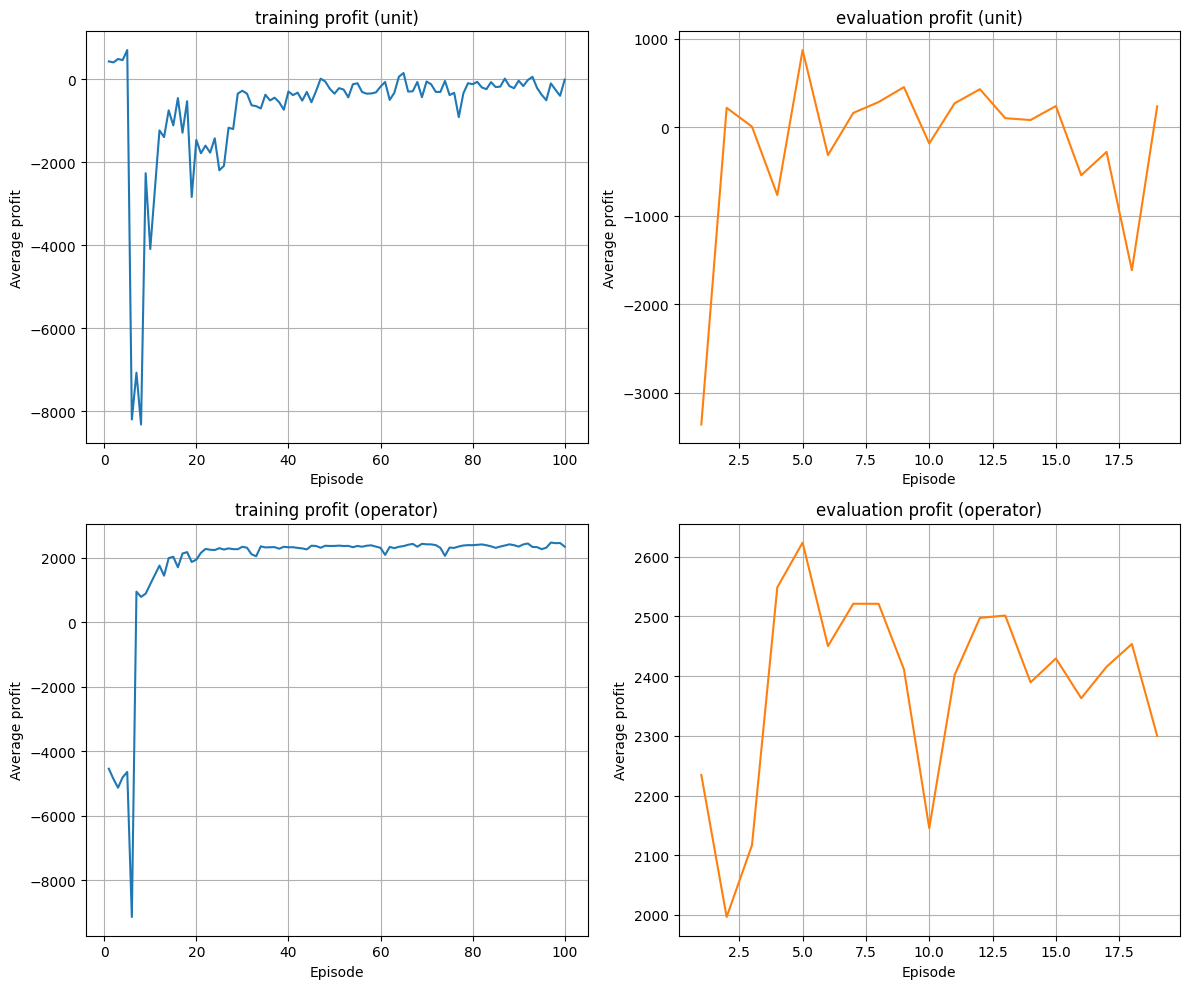

In [44]:
import matplotlib.pyplot as plt

# --- Separate plots for training and evaluation ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10),tight_layout=True)
colors = ["tab:blue", "tab:orange"]

for i, bidder in enumerate(profit_dfs):
  for j, mode in enumerate(["training", "evaluation"]):
    
    plot_df = profit_dfs[bidder]
    # training on the left, evaluation on the right
    plot_df = plot_df[plot_df["eval"] == j]
    # average profit over episode and bidders
    # each date of an episode one row, each bidder reward one col
    pivot_df = plot_df.pivot(values="profit", 
                            columns="bidder", 
                            index=["datetime", "episode"])
    # compute total profit of RL agents for that episode & date                               
    tot_profit = pivot_df.sum(axis=1)
    # average of total profit for the same date
    avg_profit = tot_profit.groupby("episode").mean()

    axes[i,j].plot(avg_profit.index, avg_profit.values, color=colors[j])
    axes[i,j].set_title(f"{mode} profit ({bidder})")
    axes[i,j].set_ylabel("Average profit")
    axes[i,j].set_xlabel("Episode")
    axes[i,j].grid(True)


**Plotting the average profits by date (evaluation only)**

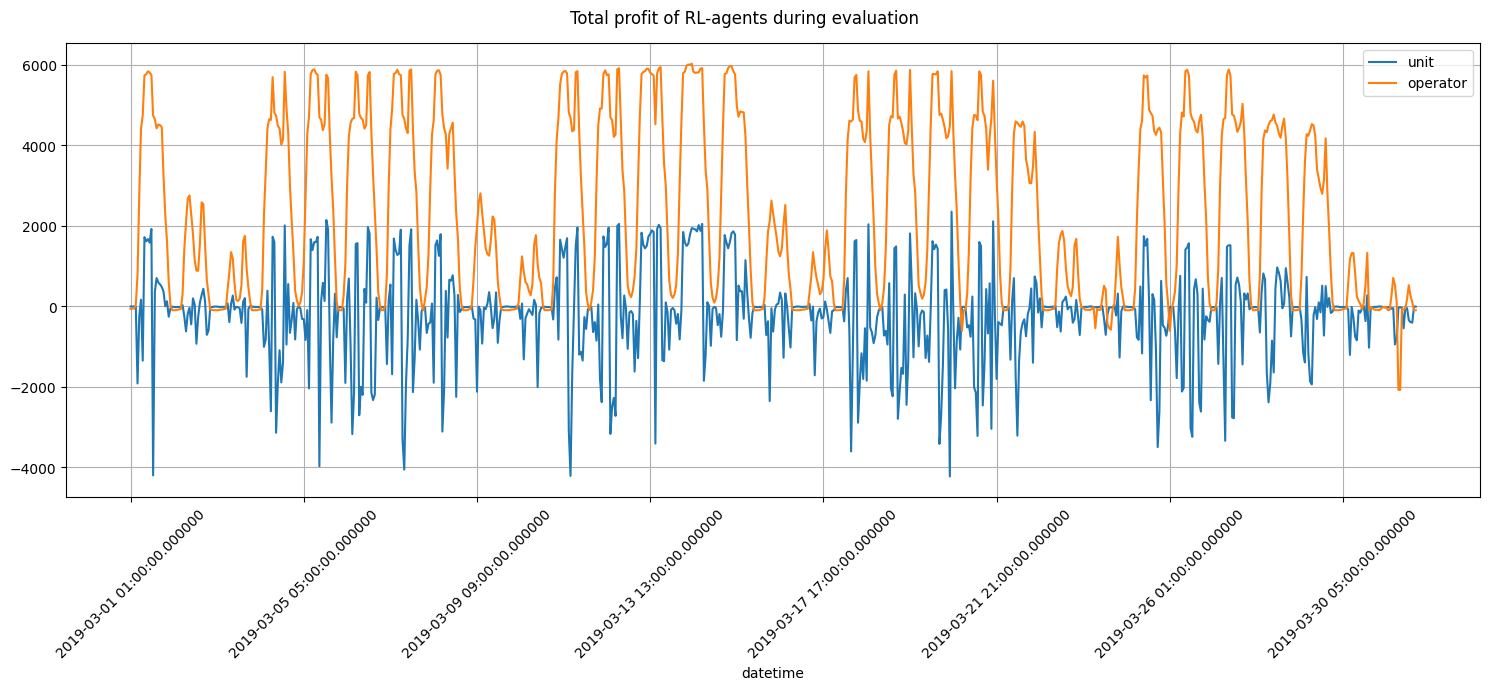

In [42]:
fig, ax = plt.subplots(tight_layout=True, figsize=(15,7))

for bidder, profit in profit_dfs.items():
    # select profit during evaluation only 
    eval_profit = profit[profit["eval"] == 1]
    # each date of an episode one row, each bidder reward one col
    eval_bidder = eval_profit.pivot(values="profit", 
                                    columns="bidder", 
                                    index=["datetime", "episode"])
    # compute total profit of RL agents for that episode & date                               
    eval_tot = eval_bidder.sum(axis=1)
    # average of total profit for the same date
    profit_by_date = eval_tot.groupby("datetime").mean()
    profit_by_date.plot(ax=ax, label=bidder)

fig.suptitle("Total profit of RL-agents during evaluation")
plt.xticks(rotation=45)
ax.legend()
ax.grid(True)


This concludes our tutorial. By following these steps, you have successfully created a RL Portfolio Strategy and integrated it into the ASSUME framework.